In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
from datetime import datetime 
import requests
import time
import schedule
from Paper_Portfolio import Portfolio 
import websockets
import yfinance as yf
import json
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [128]:
# Fetch Data with yahoo finance 

def get_ohlc_data(ticker, start_date, interval):
    
    end_date = datetime.now().strftime('%Y-%m-%d')
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

# Use the function
data = get_ohlc_data('BTC-USD', '2016-01-01', '1d')
#columns_to_convert = ['Open', 'High', 'Low', 'Close']
#data[columns_to_convert] = data[columns_to_convert].astype(float)
data['hlc3'] = (data['High'] + data['Low'] + data['Close']) / 3
data = data.drop(columns=['Volume', 'Adj Close'])

print(data)

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2016-01-01    430.721008    436.246002    427.515015    434.334015   
2016-01-02    434.622009    436.062012    431.869995    433.437988   
2016-01-03    433.578003    433.743011    424.705994    430.010986   
2016-01-04    430.061005    434.516998    429.084015    433.091003   
2016-01-05    433.069000    434.182007    429.675995    431.959991   
...                  ...           ...           ...           ...   
2024-01-05  44192.980469  44353.285156  42784.718750  44162.691406   
2024-01-06  44178.953125  44227.632812  43475.156250  43989.195312   
2024-01-07  43998.464844  44495.570312  43662.230469  43943.097656   
2024-01-08  43948.707031  47218.000000  43244.082031  46970.503906   
2024-01-09  46987.640625  47893.699219  45244.714844  46139.730469   

                    

In [129]:
# Helper Functions

def normalize(series):
    # Reshape the data
    series = pd.Series()
    series = series.values.reshape(-1, 1)
    # Fit and transform the data
    series_scaled = scaler.fit_transform(series)
    return pd.Series(series_scaled.flatten())

def rescale(series, min_val, max_val, scale_min, scale_max):
    return [(value - min_val) / (max_val - min_val) * (scale_max - scale_min) + scale_min if not np.isnan(value) else np.nan for value in series]

def get_lorentzian_distance(i, j, featureDataFrame):
    distance = 0
    for feature in featureDataFrame.columns:
        distance += np.log(1 + np.abs(featureDataFrame[feature].iloc[j] - featureDataFrame[feature].iloc[i]))
    return distance


def series_from(feature_string, f_paramA, f_paramB, data):
    switcher = {
        "RSI": n_rsi(f_paramA, f_paramB, data),
        "WT": n_wt(f_paramA, f_paramB, data),
        "CCI": n_cci(f_paramA, f_paramB, data),
    }
    return switcher.get(feature_string)

def get_feature_df(feature_params, data):
    feature_df = pd.DataFrame()
    for feature in feature_params.keys():
        feature_type = feature_params[feature][0]
        param_a = feature_params[feature][1]
        param_b = feature_params[feature][2]
        feature_df[feature] = series_from(feature_type, param_a, param_b, data)
    feature_df.index = data.index
    return feature_df

def regime_filter(data, threshold, use_regime_filter=True):
    src = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    value1 = 0.0
    value2 = 0.0
    klmf = 0.0
    prev_klmf = 0.0  # Variable to store the previous klmf value
    abs_curve_slope_list = []

    for i in range(len(data)):
        if i > 0:
            value1 = 0.2 * (src.iloc[i] - src.iloc[i-1]) + 0.8 * value1
            value2 = 0.1 * (data['High'].iloc[i] - data['Low'].iloc[i]) + 0.8 * value2
            omega = abs(value1 / value2)
            alpha = (-omega**2 + np.sqrt(omega**4 + 16 * omega**2)) / 8
            klmf = alpha * src.iloc[i] + (1 - alpha) * prev_klmf
        abs_curve_slope = abs(klmf - prev_klmf)
        abs_curve_slope_list.append(abs_curve_slope)
        prev_klmf = klmf  # Update prev_klmf for the next iteration

    data['klmf'] = [prev_klmf] * len(data)  # Assign the final klmf value to all rows
    data['abs_curve_slope'] = abs_curve_slope_list
    exponential_avg_abs_curve_slope = data['abs_curve_slope'].ewm(span=200, adjust=False).mean()
    normalized_slope_decline = (data['abs_curve_slope'] - exponential_avg_abs_curve_slope) / exponential_avg_abs_curve_slope

    if use_regime_filter:
        return normalized_slope_decline >= threshold
    else:
        return pd.Series([True] * len(data), index=data.index)
    

In [130]:
# TA indicators

def n_wt(n1, n2, data):
    ema1 = ta.ema(data.hlc3, n1)
    ema2 = ta.ema(np.abs(data.hlc3 - ema1), n1)
    ci = (data.hlc3 - ema1) / (0.015 * ema2)
    wt1 = ta.ema(ci, n2)
    wt2 = ta.sma(wt1, 4)
    wt3 = wt1 - wt2
    max_val = np.nanmax(wt3)
    min_val = np.nanmin(wt3)
    normalized_series = rescale(wt3, min_val, max_val, 0, 1)
    return normalized_series

def n_rsi(n1, n2, data):
    scaled = rescale(ta.ema(ta.rsi(data.Close, length=n1), n2), 0, 100, 0, 1)
    return scaled

def n_cci(n1, n2, data):
    ma = data.Close.rolling(window=n1).mean()
    cci = (data.Close - ma) / (0.015 * data.Close.rolling(window=n1).std(ddof=0))
    cci_ema = cci.ewm(span=n2, min_periods=n2, adjust=False).mean()
    normalized = (cci_ema - cci_ema.min()) / (cci_ema.max() - cci_ema.min())
    return normalized


In [131]:
feature_params = {
    'f1': ['RSI', 14, 1],
    'f2': ['WT', 10, 11],
    'f3': ['RSI', 9, 1],
}

feature_df = get_feature_df(feature_params, data)
feature_df

,f1,f2,f3
Date,,,
2016-01-01,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN
2016-01-04,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN
...,...,...,...
2024-01-05,0.570580,0.538153,0.569330
2024-01-06,0.561213,0.557809,0.554920
2024-01-07,0.558589,0.554570,0.550754


In [132]:
# Training Data for approximate KNN 

data_shifted = data.Close.shift(4)
y_train = pd.Series(np.zeros_like(data.Close), index = data.Close.index)
y_train[data.Close > data_shifted] = -1
y_train[data.Close < data_shifted] = 1
y_train

Date
2016-01-01    0.0
2016-01-02    0.0
2016-01-03    0.0
2016-01-04    0.0
2016-01-05    1.0
             ... 
2024-01-05    1.0
2024-01-06    1.0
2024-01-07   -1.0
2024-01-08   -1.0
2024-01-09   -1.0
Length: 2931, dtype: float64

In [133]:
# Calculate Historical Data for prediction Series
max_bars_back = 2000
neighbors = 8
p_vals = []
prediction = 8
predictions_all = []
distances_all = []

# Core algorithm 

for k in range(0, len(data)):
    if k >= max_bars_back-1:
        lastDistance = -1
        count = -1
        
        for j in range(k-max_bars_back+1, k):
            d = get_lorentzian_distance(j, k, feature_df)
            count += 1
            if d >= lastDistance and count%4 == 0:
                lastDistance = d
                distances_all.append(d)
                predictions_all.append(round(y_train[j]))
                if len(predictions_all) > neighbors:
                    lastDistance = np.percentile(distances_all, 25)
                    distances_all = distances_all[1:]
                    predictions_all = predictions_all[1:]
            prediction = sum(predictions_all)
          
    p_vals.append(prediction)

In [134]:
# Regime Filter Series for modifying Signal Generation frequency 

r_g = regime_filter(data, 0.1, True)
r_g

Date
2016-01-01    False
2016-01-02     True
2016-01-03     True
2016-01-04     True
2016-01-05     True
              ...  
2024-01-05    False
2024-01-06    False
2024-01-07    False
2024-01-08     True
2024-01-09     True
Name: abs_curve_slope, Length: 2931, dtype: bool

In [135]:
# Create a signal series based on prediction values
signal = []
for i in range(len(p_vals)):
    if p_vals[i] > 0 and r_g[i] == True:
        signal.append(1)
    elif p_vals[i] < 0 and r_g[i] == True:
        signal.append(-1)
    else:
        if i == 0:
            signal.append(0)
        else:
            signal.append(signal[i-1])
signal = pd.Series(signal, index = data.Close.index)

In [136]:
# Create a series that is 1 when the signal is positive and 0 when it's negative
signs = np.sign(signal)
signs = (signs > 0).astype(int)

# Create a series that increments when the sign changes
groups = signs.diff().ne(0).cumsum()

# Count consecutive positive or negative values
barsHeld = groups.groupby(groups).cumcount() + 1

# Create isHeldFourBars
isHeldFourBars = barsHeld >= 4

# Create isHeldLessThanFourBars
isHeldLessThanFourBars = (0 < barsHeld) & (barsHeld < 4)

In [137]:
# Create isDifferentSignalType
isDifferentSignalType = signal.diff() != 0

# Create isEarlySignalFlip
isEarlySignalFlip = isDifferentSignalType & ((signal.shift(1).diff() != 0) | (signal.shift(2).diff() != 0) | (signal.shift(3).diff() != 0))

# Create isBuySignal
isBuySignal = signal == 1

# Create isSellSignal
isSellSignal = signal == -1

# Create isLastSignalBuy
isLastSignalBuy = ((signal.shift(4) == 1) & (signal.shift(3) == 1) & (signal.shift(3) == 1) & (signal.shift(1) == 1))

# Create isLastSignalSell
isLastSignalSell = ((signal.shift(4) == -1) & (signal.shift(3) == -1) & (signal.shift(3) == -1) & (signal.shift(1) == -1))

# Create isNewBuySignal
isNewBuySignal = isBuySignal & isDifferentSignalType

# Create isNewSellSignal
isNewSellSignal = isSellSignal & isDifferentSignalType

In [138]:
# Create endLongTradeStrict
endLongTradeStrict = (((isHeldFourBars & isLastSignalBuy) | (isNewSellSignal & isLastSignalBuy)) & isNewBuySignal.shift(4)) | (isEarlySignalFlip & ~isNewBuySignal)

# Create endShortTradeStrict
endShortTradeStrict = (((isHeldFourBars & isLastSignalSell) | (isNewBuySignal & isLastSignalSell)) & isNewSellSignal.shift(4)) | (isEarlySignalFlip & ~isNewSellSignal)

In [139]:
buy_filtered = isNewBuySignal[isNewBuySignal]
sell_filtered = isNewSellSignal[isNewSellSignal]
buy_exit_filtered = endLongTradeStrict[endLongTradeStrict]
sell_exit_filtered = endShortTradeStrict[endShortTradeStrict]

In [140]:
buy_filtered = pd.Series(buy_filtered)
sell_filtered = pd.Series(sell_filtered)
buy_exit_filtered = pd.Series(buy_exit_filtered)
sell_exit_filtered = pd.Series(sell_exit_filtered)
buy_df = pd.concat([buy_filtered, buy_exit_filtered], axis=1)
mask = buy_df[1] != buy_df[1].shift(1)

# Apply the mask to the dataframe
buy_df = buy_df[mask]
sell_df = pd.concat([sell_filtered, sell_exit_filtered], axis=1)
mask = sell_df[1] != sell_df[1].shift(1)
sell_df = sell_df[mask]

In [141]:
experiment_df = data.loc[buy_df.index, 'Close']
open_df = data.loc[buy_df.index, 'Open']
buy_df = pd.concat([buy_df, experiment_df], axis=1)
buy_df = pd.concat([buy_df, open_df], axis=1)
buy_df = buy_df.drop(buy_df.index[0])
buy_df = buy_df.drop(buy_df.index[0])
buy_df.tail(50)

,0,1,Close,Open
Date,,,,
2016-01-06,NaN,True,429.105011,431.855988
2021-07-24,True,NaN,34292.445312,33593.730469
2021-07-28,NaN,True,39995.906250,39503.187500
2021-10-01,True,NaN,48116.941406,43816.742188
2021-10-05,NaN,True,51514.812500,49174.960938
2021-12-24,True,NaN,50822.195312,50806.050781
2021-12-28,NaN,True,47588.855469,50679.859375
2022-02-05,True,NaN,41441.164062,41501.480469
2022-02-09,NaN,True,44338.796875,44096.703125


In [142]:
experiment_df2 = data.loc[sell_df.index, 'Close']
open_df2 = data.loc[sell_df.index, 'Open']
sell_df = pd.concat([sell_df, experiment_df2], axis=1)
sell_df = pd.concat([sell_df, open_df2], axis=1)
sell_df = sell_df.drop(sell_df.index[0])
#sell_df.tail(50)

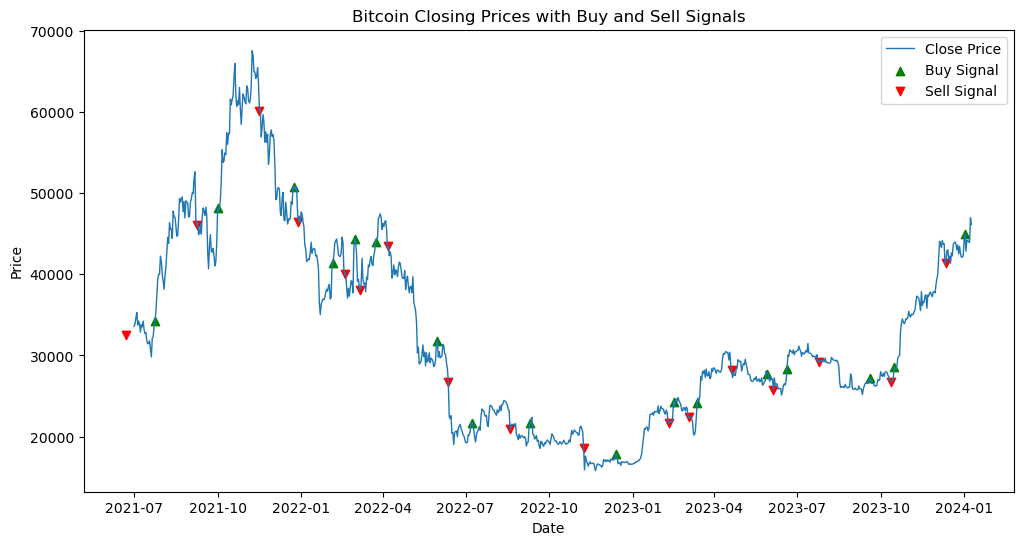

In [143]:
buy_df = buy_df.fillna(False)
sell_df = sell_df.fillna(False)
buy_dates = buy_df.index[buy_df[0]]
sell_dates = sell_df.index[sell_df[0]]

plot_data = data.loc['2021-07-01':]

plt.figure(figsize=(12,6))
plt.plot(plot_data.index, plot_data['Close'], label='Close Price', linewidth=1)

# Overlay buy signals
buy_prices = data.loc[buy_dates, 'Close']
plt.scatter(buy_dates, buy_prices, color='green', marker='^', alpha=1, label='Buy Signal')

# Overlay sell signals
sell_prices = data.loc[sell_dates, 'Close']
plt.scatter(sell_dates, sell_prices, color='red', marker='v', alpha=1, label='Sell Signal')

plt.title('Bitcoin Closing Prices with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()